## Reinforcement learning in electricity trading

In this notebook, we adapt the Q-learning agent which we developed in the notebook named RL_Project(Own Environement) and adapt it to work in the test environment that is provided by the lecturer. 

In [1]:
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from random import randrange
import gym


np.random.seed(15)
random.seed(5)

## Environment

The test environment, coded according to the template given by the course lecturer. 

In [2]:


class Electric_Car(gym.Env):
    def __init__(self, path_to_test_data=str):
        # Define a continuous action space, -1 to 1. (You can discretize this later!)
        self.continuous_action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # Define the test data
        self.test_data = pd.read_excel(path_to_test_data)
        self.price_values = self.test_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.test_data['PRICES']
        self.state = np.empty(7)

        # Battery characteristics
        self.battery_capacity = 50  # kWh
        self.max_power = 25 / 0.9  # kW
        self.charge_efficiency = 0.9  # -
        self.discharge_efficiency = 0.9  # -
        self.battery_level = self.battery_capacity / 2  # kWh (start at 50%)
        self.minimum_morning_level = 20  # kWh
        self.car_use_consumption = 20  # kWh

        # Time Tracking
        self.counter = 0
        self.hour = 1
        self.day = 1
        self.car_is_available = True

    def step(self, action):

        action = np.squeeze(action)  # Remove the extra dimension

        if action <-1 or action >1:
            raise ValueError('Action must be between -1 and 1')

        # Calculate if, at 7am and after the chosen action, the battery level will be below the minimum morning level:
        if self.hour == 8:
            if action > 0 and (self.battery_level < self.minimum_morning_level):
                if (
                        self.battery_level + action * self.max_power * self.charge_efficiency) < self.minimum_morning_level:  # If the chosen action will not charge the battery to 20kWh
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)  # Charge until 20kWh
            elif action < 0:
                if (self.battery_level + action * self.max_power) < self.minimum_morning_level:
                    if self.battery_level < self.minimum_morning_level:  # If the level was lower than 20kWh, charge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                                    self.max_power * self.charge_efficiency)  # Charge until 20kWh
                    elif self.battery_level >= self.minimum_morning_level:  # If the level was higher than 20kWh, discharge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                            self.max_power)  # Discharge until 20kWh
            elif action == 0:
                if self.battery_level < self.minimum_morning_level:
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)

        if not self.car_is_available:
            action = 0

        # Calculate the costs and battery level when charging (action >0)
        if (action > 0) and (self.battery_level <= self.battery_capacity):
            if (self.battery_level + action * self.max_power * self.charge_efficiency) > self.battery_capacity:
                action = (self.battery_capacity - self.battery_level) / (self.max_power * self.charge_efficiency)
            charged_electricity_kW = action * self.max_power
            charged_electricity_costs = charged_electricity_kW * self.price_values[self.day - 1][
                self.hour-1] * 2 * 1e-3
            reward = -charged_electricity_costs
            self.battery_level += charged_electricity_kW * self.charge_efficiency
        # Calculate the profits and battery level when discharging (action <0)
        elif (action < 0) and (self.battery_level >= 0):
            if (self.battery_level + action * self.max_power) < 0:
                action = -self.battery_level / (self.max_power)
            discharged_electricity_kWh = action * self.max_power  # Negative discharge value
            discharged_electricity_profits = abs(discharged_electricity_kWh) * self.discharge_efficiency * \
                                             self.price_values[self.day - 1][self.hour-1] * 1e-3
            reward = discharged_electricity_profits
            self.battery_level += discharged_electricity_kWh
            # Some small numerical errors causing the battery level to be 1e-14 to 1e-17 under 0 :
            if self.battery_level < 0:
                self.battery_level = 0

        else:
            reward = 0

        self.counter += 1  # Increase the counter
        self.hour += 1  # Increase the hour

        # There is a 50% chance that the car is unavailable from 8am to 6pm
        if self.hour == 9:
            self.car_is_available = np.random.choice([True, False])
            if not self.car_is_available:
                self.battery_level -= self.car_use_consumption
        if self.hour == 19:
            self.car_is_available = True

        if self.counter % 24 == 0:  # If the counter is a multiple of 24, increase the day, reset hour to first hour
            self.day += 1
            self.hour = 1

        terminated = self.counter == len(
            self.price_values.flatten()) - 1  # If the counter is equal to the number of hours in the test data, terminate the episode
        truncated = False

        info = action  # The final action taken after all constraints! For debugging purposes

        self.state = self.observation()  # Update the state

        return self.state, reward, terminated, truncated, info

    def observation(self):  # Returns the current state
        battery_level = self.battery_level
        price = self.price_values[self.day - 1][self.hour-1]
        hour = self.hour
        day_of_week = self.timestamps[self.day - 1].dayofweek  # Monday = 0, Sunday = 6
        day_of_year = self.timestamps[self.day - 1].dayofyear  # January 1st = 1, December 31st = 365
        month = self.timestamps[self.day - 1].month  # January = 1, December = 12
        year = self.timestamps[self.day - 1].year
        self.state = np.array(
            [battery_level, price, int(hour), int(day_of_week), int(day_of_year), int(month), int(year),
             int(self.car_is_available)])

        return self.state

## Action Space (Agent)

The CustomDiscreteActionSpace class defines a custom discrete range of actions from start to end with a specified step size. It extends Gym’s Discrete class and calculates the total number of discrete actions based on the range and step. The map_to_action method converts an action index into its corresponding real-world value, allowing the agent to take interpretable, discretized energy actions.

In [3]:
class CustomDiscreteActionSpace(spaces.Discrete):
    def __init__(self, start=-25, end=25, step=12.5):
        num_actions = int((end - start) / step) + 1
        super(CustomDiscreteActionSpace, self).__init__(num_actions)
        self.start = start
        self.step_size = step
        self.end = end
    def map_to_action(self, action_index):
        return self.start + action_index * self.step_size

custom_action_space = CustomDiscreteActionSpace()

## Define Q-Agent

This Q-Agent uses tabular Q-learning with a custom discrete action space mapped to continuous values, optimizing EV energy trading under real-world constraints. It discretizes battery level, electricity price, and time to form a compact state space, and applies action masking and reward shaping to guide learning. The agent trains over multiple episodes with decaying learning and exploration rates, logging profits for performance tracking.

In [4]:
class QAgent():
    def __init__(self, env, action_space=custom_action_space, discount_rate = 0.95, learning_rate=0.3, epsilon=0.5):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.price_bins = np.array([-1,20,27,32,37,43,50,60,72,88,3000]) 
        self.action_space = action_space
        self.state_space = [5, len(self.price_bins)-1, 24, self.action_space.n]
        self.Qtable = np.zeros(self.state_space)
        self.profit = []
        self.time_constraint = 8
        self.all_profits = []
        self.max_power = 25

    def mask(self):
        # 7 am constraint  
        if self.env.hour == self.time_constraint and self.env.battery_level >= self.env.minimum_morning_level:
            lower_bound = min(np.ceil((self.env.minimum_morning_level - self.env.battery_level)*0.9), self.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.hour == self.time_constraint and self.env.battery_level < self.env.minimum_morning_level:
            lower_bound = min(np.ceil((self.env.minimum_morning_level - self.env.battery_level)/0.9), self.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.battery_level)*0.9), -self.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
                
        # construct boolean mask_vector
        mask = np.arange(self.action_space.start, self.action_space.end + 1, self.action_space.step_size) 
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def reward_shape(self, reward, continuous_action):
        if continuous_action < 0:
            reward -= 0.05 * 25
        return reward

    def to_continuous(self, action):
        continuous = np.linspace(-1 , 1, 5)
        return continuous[action]

    def discretize_features(self, features):
        battery, price, hour  = features[0], features[1], features[2]
        return tuple([int(battery//10.001), np.max(np.where(self.price_bins<price)), int(hour - 1)])

    def reset(self):
        # Battery characteristics
        self.env.battery_level = self.env.battery_capacity / 2  # kWh (start at 50%)

        # Time Tracking
        self.env.counter = 0
        self.env.hour = 1
        self.env.day = 1
        self.env.car_is_available = True
        
    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()

        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            
            action = np.random.choice(np.arange(self.action_space.n)[mask])
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        return action

    def train(self, simulations = 100, epsilon = 0.1):
        for i in range(simulations):
            done = False
            profits = 0
            self.epsilon = max(0.05, self.epsilon - 0.05)
            self.learning_rate *= 0.9
            while not done:    
                current_state = self.env.observation()
                current_state = self.discretize_features(current_state) 
                action = self.select_action_epsilon_greedy(current_state)
                continuous_action = self.to_continuous(action)
                
                next_state, reward, done, truncated, info = self.env.step(continuous_action)
                profits += reward
                
                next_state = self.discretize_features(next_state)
                next_state_mask = self.mask()
                reward = self.reward_shape(reward, continuous_action)
                
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta

            print(f'{i} simulations done')
            self.all_profits.append(profits)
            self.reset()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action


    def plot_profits(self):
        plt.plot(self.all_profits)
        plt.xlabel('Epochs')
        plt.ylabel('Profit')
        plt.title("Profit per epoch")

## Train

Here we train the agent in 16 epochs.

0 simulations done
1 simulations done
2 simulations done
3 simulations done
4 simulations done
5 simulations done
6 simulations done
7 simulations done
8 simulations done
9 simulations done
10 simulations done
11 simulations done
12 simulations done
13 simulations done
14 simulations done
15 simulations done


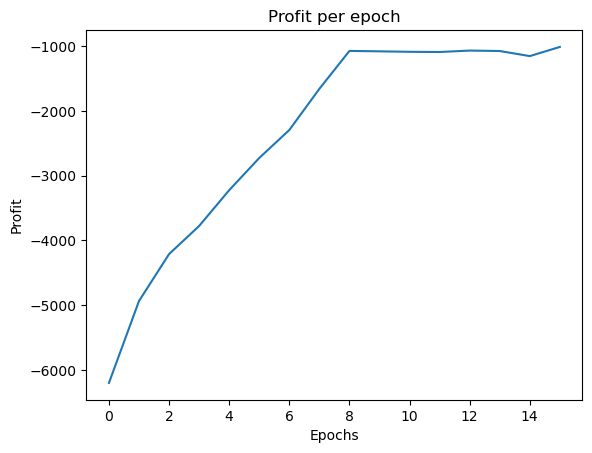

In [5]:
env = Electric_Car(path_to_test_data='train.xlsx')
agent = QAgent(env, action_space=custom_action_space)
agent.train(simulations=16)
agent.plot_profits()

## Eval

We evaluate the agent on the validation set.

In [6]:
eval_env = Electric_Car(path_to_test_data='validate.xlsx')
agent.env = eval_env
discrete_act = [-25, -12.5, 0, 12.5, 25]
done = False
profits = 0

while not done:
    current_state = agent.env.observation()
    battery, price, hour  = current_state[0], current_state[1], current_state[2]
    current_state = agent.discretize_features(current_state)
    
    action = agent.predict(current_state)
    continuous_action = agent.to_continuous(action)
    if agent.env.car_is_available:
        print(f"at time {hour} agent transacts {discrete_act[action]}, price is {price} battery is {battery}")
    next_state, reward, done, trucated, info = agent.env.step(continuous_action)
    profits += reward




at time 1.0 agent transacts 0, price is 13.2 battery is 25.0
at time 2.0 agent transacts 0, price is 13.14 battery is 25.0
at time 3.0 agent transacts 0, price is 11.83 battery is 25.0
at time 4.0 agent transacts 0, price is 9.49 battery is 25.0
at time 5.0 agent transacts 0, price is 8.63 battery is 25.0
at time 6.0 agent transacts 0, price is 7.12 battery is 25.0
at time 7.0 agent transacts 0, price is 4.06 battery is 25.0
at time 8.0 agent transacts 0, price is 1.0 battery is 25.0
at time 9.0 agent transacts 0, price is 8.4 battery is 25.0
at time 10.0 agent transacts 0, price is 9.11 battery is 25.0
at time 11.0 agent transacts 0, price is 10.18 battery is 25.0
at time 12.0 agent transacts 0, price is 13.56 battery is 25.0
at time 13.0 agent transacts 25, price is 18.02 battery is 25.0
at time 14.0 agent transacts 0, price is 15.02 battery is 50.0
at time 15.0 agent transacts 0, price is 12.58 battery is 50.0
at time 16.0 agent transacts 0, price is 10.18 battery is 50.0
at time 17

at time 22.0 agent transacts 0, price is 42.42 battery is 32.22222222222222
at time 23.0 agent transacts 0, price is 43.16 battery is 32.22222222222222
at time 24.0 agent transacts 0, price is 42.63 battery is 32.22222222222222
at time 1.0 agent transacts 0, price is 37.71 battery is 32.22222222222222
at time 2.0 agent transacts 0, price is 34.15 battery is 32.22222222222222
at time 3.0 agent transacts 0, price is 31.0 battery is 32.22222222222222
at time 4.0 agent transacts 0, price is 27.0 battery is 32.22222222222222
at time 5.0 agent transacts 0, price is 27.97 battery is 32.22222222222222
at time 6.0 agent transacts 0, price is 33.0 battery is 32.22222222222222
at time 7.0 agent transacts 0, price is 43.45 battery is 32.22222222222222
at time 8.0 agent transacts 0, price is 53.6 battery is 32.22222222222222
at time 19.0 agent transacts 0, price is 58.85 battery is 12.222222222222221
at time 20.0 agent transacts 0, price is 50.0 battery is 12.222222222222221
at time 21.0 agent tran

at time 1.0 agent transacts 0, price is 38.15 battery is 26.388888888888886
at time 2.0 agent transacts 0, price is 37.0 battery is 26.388888888888886
at time 3.0 agent transacts 0, price is 34.0 battery is 26.388888888888886
at time 4.0 agent transacts 0, price is 29.57 battery is 26.388888888888886
at time 5.0 agent transacts 0, price is 29.0 battery is 26.388888888888886
at time 6.0 agent transacts 0, price is 34.43 battery is 26.388888888888886
at time 7.0 agent transacts 0, price is 42.0 battery is 26.388888888888886
at time 8.0 agent transacts 0, price is 54.2 battery is 26.388888888888886
at time 9.0 agent transacts 0, price is 57.01 battery is 26.388888888888886
at time 10.0 agent transacts 0, price is 59.64 battery is 26.388888888888886
at time 11.0 agent transacts 0, price is 58.76 battery is 26.388888888888886
at time 12.0 agent transacts 0, price is 59.99 battery is 26.388888888888886
at time 13.0 agent transacts 0, price is 57.42 battery is 26.388888888888886
at time 14.0 

at time 15.0 agent transacts 0, price is 43.8 battery is 28.888888888888886
at time 16.0 agent transacts 0, price is 40.12 battery is 28.888888888888886
at time 17.0 agent transacts 0, price is 40.15 battery is 28.888888888888886
at time 18.0 agent transacts 0, price is 40.0 battery is 28.888888888888886
at time 19.0 agent transacts 0, price is 45.81 battery is 28.888888888888886
at time 20.0 agent transacts 0, price is 57.29 battery is 28.888888888888886
at time 21.0 agent transacts 0, price is 50.0 battery is 28.888888888888886
at time 22.0 agent transacts 0, price is 42.49 battery is 28.888888888888886
at time 23.0 agent transacts 0, price is 40.34 battery is 28.888888888888886
at time 24.0 agent transacts 0, price is 37.5 battery is 28.888888888888886
at time 1.0 agent transacts 0, price is 34.6 battery is 28.888888888888886
at time 2.0 agent transacts 0, price is 31.18 battery is 28.888888888888886
at time 3.0 agent transacts 0, price is 29.3 battery is 28.888888888888886
at time 

at time 19.0 agent transacts 0, price is 43.23 battery is 6.388888888888886
at time 20.0 agent transacts 0, price is 45.04 battery is 6.388888888888886
at time 21.0 agent transacts 0, price is 50.0 battery is 6.388888888888886
at time 22.0 agent transacts 0, price is 46.86 battery is 6.388888888888886
at time 23.0 agent transacts 0, price is 44.6 battery is 6.388888888888886
at time 24.0 agent transacts 0, price is 40.0 battery is 6.388888888888886
at time 1.0 agent transacts 0, price is 37.0 battery is 6.388888888888886
at time 2.0 agent transacts 0, price is 34.02 battery is 6.388888888888886
at time 3.0 agent transacts 0, price is 32.5 battery is 6.388888888888886
at time 4.0 agent transacts 0, price is 31.0 battery is 6.388888888888886
at time 5.0 agent transacts 25, price is 32.01 battery is 6.388888888888886
at time 6.0 agent transacts 0, price is 39.25 battery is 31.388888888888886
at time 7.0 agent transacts 0, price is 43.56 battery is 31.388888888888886
at time 8.0 agent tran

at time 20.0 agent transacts 0, price is 49.71 battery is 28.888888888888886
at time 21.0 agent transacts 0, price is 49.48 battery is 28.888888888888886
at time 22.0 agent transacts 0, price is 51.17 battery is 28.888888888888886
at time 23.0 agent transacts 0, price is 50.97 battery is 28.888888888888886
at time 24.0 agent transacts 0, price is 44.0 battery is 28.888888888888886
at time 1.0 agent transacts 0, price is 41.52 battery is 28.888888888888886
at time 2.0 agent transacts 0, price is 36.95 battery is 28.888888888888886
at time 3.0 agent transacts 0, price is 36.0 battery is 28.888888888888886
at time 4.0 agent transacts 0, price is 33.88 battery is 28.888888888888886
at time 5.0 agent transacts 0, price is 33.65 battery is 28.888888888888886
at time 6.0 agent transacts 0, price is 38.93 battery is 28.888888888888886
at time 7.0 agent transacts 0, price is 48.86 battery is 28.888888888888886
at time 8.0 agent transacts 0, price is 58.0 battery is 28.888888888888886
at time 9.

at time 24.0 agent transacts 0, price is 38.98 battery is 3.8888888888888857
at time 1.0 agent transacts 0, price is 41.41 battery is 3.8888888888888857
at time 2.0 agent transacts 0, price is 36.43 battery is 3.8888888888888857
at time 3.0 agent transacts 0, price is 31.56 battery is 3.8888888888888857
at time 4.0 agent transacts 25, price is 19.19 battery is 3.8888888888888857
at time 5.0 agent transacts 0, price is 16.26 battery is 28.888888888888886
at time 6.0 agent transacts 0, price is 17.19 battery is 28.888888888888886
at time 7.0 agent transacts 0, price is 16.16 battery is 28.888888888888886
at time 8.0 agent transacts 0, price is 21.07 battery is 28.888888888888886
at time 19.0 agent transacts 0, price is 42.87 battery is 8.888888888888886
at time 20.0 agent transacts 0, price is 42.37 battery is 8.888888888888886
at time 21.0 agent transacts 0, price is 39.0 battery is 8.888888888888886
at time 22.0 agent transacts 0, price is 39.5 battery is 8.888888888888886
at time 23.0

at time 12.0 agent transacts 0, price is 50.87 battery is 31.388888888888886
at time 13.0 agent transacts 0, price is 52.5 battery is 31.388888888888886
at time 14.0 agent transacts 0, price is 48.28 battery is 31.388888888888886
at time 15.0 agent transacts 0, price is 47.3 battery is 31.388888888888886
at time 16.0 agent transacts 0, price is 44.14 battery is 31.388888888888886
at time 17.0 agent transacts 0, price is 42.68 battery is 31.388888888888886
at time 18.0 agent transacts 0, price is 42.18 battery is 31.388888888888886
at time 19.0 agent transacts 0, price is 44.46 battery is 31.388888888888886
at time 20.0 agent transacts 0, price is 43.95 battery is 31.388888888888886
at time 21.0 agent transacts 0, price is 42.2 battery is 31.388888888888886
at time 22.0 agent transacts 0, price is 41.74 battery is 31.388888888888886
at time 23.0 agent transacts 0, price is 49.84 battery is 31.388888888888886
at time 24.0 agent transacts 0, price is 44.6 battery is 31.388888888888886
at 

at time 11.0 agent transacts 0, price is 53.19 battery is 33.888888888888886
at time 12.0 agent transacts 0, price is 54.69 battery is 33.888888888888886
at time 13.0 agent transacts 0, price is 54.73 battery is 33.888888888888886
at time 14.0 agent transacts 0, price is 53.0 battery is 33.888888888888886
at time 15.0 agent transacts 0, price is 52.99 battery is 33.888888888888886
at time 16.0 agent transacts 0, price is 48.49 battery is 33.888888888888886
at time 17.0 agent transacts 0, price is 48.25 battery is 33.888888888888886
at time 18.0 agent transacts 0, price is 47.35 battery is 33.888888888888886
at time 19.0 agent transacts 0, price is 47.67 battery is 33.888888888888886
at time 20.0 agent transacts 0, price is 45.67 battery is 33.888888888888886
at time 21.0 agent transacts 0, price is 43.72 battery is 33.888888888888886
at time 22.0 agent transacts 0, price is 43.5 battery is 33.888888888888886
at time 23.0 agent transacts 0, price is 47.0 battery is 33.888888888888886
at

at time 19.0 agent transacts 0, price is 46.12 battery is 6.388888888888886
at time 20.0 agent transacts 0, price is 45.01 battery is 6.388888888888886
at time 21.0 agent transacts 0, price is 44.57 battery is 6.388888888888886
at time 22.0 agent transacts 0, price is 44.76 battery is 6.388888888888886
at time 23.0 agent transacts 0, price is 44.37 battery is 6.388888888888886
at time 24.0 agent transacts 0, price is 42.33 battery is 6.388888888888886
at time 1.0 agent transacts 0, price is 40.0 battery is 6.388888888888886
at time 2.0 agent transacts 0, price is 36.5 battery is 6.388888888888886
at time 3.0 agent transacts 0, price is 13.17 battery is 6.388888888888886
at time 4.0 agent transacts 25, price is 10.33 battery is 6.388888888888886
at time 5.0 agent transacts 0, price is 10.33 battery is 31.388888888888886
at time 6.0 agent transacts 0, price is 10.29 battery is 31.388888888888886
at time 7.0 agent transacts 0, price is 10.36 battery is 31.388888888888886
at time 8.0 agent

at time 10.0 agent transacts 0, price is 50.29 battery is 31.388888888888886
at time 11.0 agent transacts 0, price is 51.31 battery is 31.388888888888886
at time 12.0 agent transacts 0, price is 53.02 battery is 31.388888888888886
at time 13.0 agent transacts 0, price is 52.12 battery is 31.388888888888886
at time 14.0 agent transacts 0, price is 50.56 battery is 31.388888888888886
at time 15.0 agent transacts 0, price is 50.21 battery is 31.388888888888886
at time 16.0 agent transacts 0, price is 49.25 battery is 31.388888888888886
at time 17.0 agent transacts 0, price is 48.01 battery is 31.388888888888886
at time 18.0 agent transacts 0, price is 47.52 battery is 31.388888888888886
at time 19.0 agent transacts 0, price is 48.62 battery is 31.388888888888886
at time 20.0 agent transacts 0, price is 47.35 battery is 31.388888888888886
at time 21.0 agent transacts 0, price is 50.81 battery is 31.388888888888886
at time 22.0 agent transacts 0, price is 46.61 battery is 31.388888888888886

at time 23.0 agent transacts 0, price is 48.41 battery is 33.888888888888886
at time 24.0 agent transacts 0, price is 45.07 battery is 33.888888888888886
at time 1.0 agent transacts 0, price is 43.39 battery is 33.888888888888886
at time 2.0 agent transacts 0, price is 41.01 battery is 33.888888888888886
at time 3.0 agent transacts 0, price is 38.08 battery is 33.888888888888886
at time 4.0 agent transacts 0, price is 35.08 battery is 33.888888888888886
at time 5.0 agent transacts 0, price is 35.14 battery is 33.888888888888886
at time 6.0 agent transacts 0, price is 39.0 battery is 33.888888888888886
at time 7.0 agent transacts 0, price is 46.73 battery is 33.888888888888886
at time 8.0 agent transacts 0, price is 57.02 battery is 33.888888888888886
at time 9.0 agent transacts 0, price is 61.0 battery is 33.888888888888886
at time 10.0 agent transacts 0, price is 60.62 battery is 33.888888888888886
at time 11.0 agent transacts 0, price is 60.82 battery is 33.888888888888886
at time 12

at time 1.0 agent transacts 0, price is 38.27 battery is 25.83333333333333
at time 2.0 agent transacts 0, price is 37.21 battery is 25.83333333333333
at time 3.0 agent transacts 0, price is 30.11 battery is 25.83333333333333
at time 4.0 agent transacts 0, price is 10.37 battery is 25.83333333333333
at time 5.0 agent transacts 0, price is 14.62 battery is 25.83333333333333
at time 6.0 agent transacts 0, price is 32.09 battery is 25.83333333333333
at time 7.0 agent transacts 0, price is 42.95 battery is 25.83333333333333
at time 8.0 agent transacts 0, price is 50.03 battery is 25.83333333333333
at time 9.0 agent transacts 0, price is 53.19 battery is 25.83333333333333
at time 10.0 agent transacts 0, price is 55.11 battery is 25.83333333333333
at time 11.0 agent transacts 0, price is 55.02 battery is 25.83333333333333
at time 12.0 agent transacts 0, price is 57.25 battery is 25.83333333333333
at time 13.0 agent transacts 0, price is 59.24 battery is 25.83333333333333
at time 14.0 agent tr

at time 4.0 agent transacts 0, price is 43.59 battery is 5.2777777777777715
at time 5.0 agent transacts 0, price is 42.36 battery is 5.2777777777777715
at time 6.0 agent transacts 25, price is 50.24 battery is 5.2777777777777715
at time 7.0 agent transacts 0, price is 58.37 battery is 30.27777777777777
at time 8.0 agent transacts 0, price is 67.4 battery is 30.27777777777777
at time 9.0 agent transacts 0, price is 66.39 battery is 30.27777777777777
at time 10.0 agent transacts 0, price is 68.05 battery is 30.27777777777777
at time 11.0 agent transacts 0, price is 66.87 battery is 30.27777777777777
at time 12.0 agent transacts 0, price is 69.46 battery is 30.27777777777777
at time 13.0 agent transacts 0, price is 69.66 battery is 30.27777777777777
at time 14.0 agent transacts 0, price is 69.94 battery is 30.27777777777777
at time 15.0 agent transacts 0, price is 78.02 battery is 30.27777777777777
at time 16.0 agent transacts 0, price is 81.45 battery is 30.27777777777777
at time 17.0 ag

at time 21.0 agent transacts 0, price is 59.5 battery is 30.55555555555555
at time 22.0 agent transacts 0, price is 57.97 battery is 30.55555555555555
at time 23.0 agent transacts 0, price is 67.43 battery is 30.55555555555555
at time 24.0 agent transacts 0, price is 63.36 battery is 30.55555555555555
at time 1.0 agent transacts 0, price is 56.77 battery is 30.55555555555555
at time 2.0 agent transacts 0, price is 53.1 battery is 30.55555555555555
at time 3.0 agent transacts 0, price is 49.49 battery is 30.55555555555555
at time 4.0 agent transacts 0, price is 44.11 battery is 30.55555555555555
at time 5.0 agent transacts 0, price is 35.91 battery is 30.55555555555555
at time 6.0 agent transacts 0, price is 39.82 battery is 30.55555555555555
at time 7.0 agent transacts 0, price is 42.18 battery is 30.55555555555555
at time 8.0 agent transacts 0, price is 42.68 battery is 30.55555555555555
at time 9.0 agent transacts 0, price is 48.55 battery is 30.55555555555555
at time 10.0 agent tran

at time 19.0 agent transacts 0, price is 69.73 battery is 8.05555555555555
at time 20.0 agent transacts 0, price is 66.83 battery is 8.05555555555555
at time 21.0 agent transacts 0, price is 63.71 battery is 8.05555555555555
at time 22.0 agent transacts 0, price is 53.02 battery is 8.05555555555555
at time 23.0 agent transacts 0, price is 52.6 battery is 8.05555555555555
at time 24.0 agent transacts 0, price is 48.46 battery is 8.05555555555555
at time 1.0 agent transacts 0, price is 46.04 battery is 8.05555555555555
at time 2.0 agent transacts 0, price is 45.3 battery is 8.05555555555555
at time 3.0 agent transacts 0, price is 44.88 battery is 8.05555555555555
at time 4.0 agent transacts 0, price is 42.65 battery is 8.05555555555555
at time 5.0 agent transacts 0, price is 42.09 battery is 8.05555555555555
at time 6.0 agent transacts 12.5, price is 45.7 battery is 8.05555555555555
at time 7.0 agent transacts 0, price is 50.83 battery is 20.55555555555555
at time 8.0 agent transacts 0, 

at time 1.0 agent transacts 0, price is 52.81 battery is 28.05555555555555
at time 2.0 agent transacts 0, price is 51.14 battery is 28.05555555555555
at time 3.0 agent transacts 0, price is 48.47 battery is 28.05555555555555
at time 4.0 agent transacts 0, price is 44.46 battery is 28.05555555555555
at time 5.0 agent transacts 0, price is 43.89 battery is 28.05555555555555
at time 6.0 agent transacts 0, price is 43.47 battery is 28.05555555555555
at time 7.0 agent transacts 0, price is 43.08 battery is 28.05555555555555
at time 8.0 agent transacts 0, price is 43.81 battery is 28.05555555555555
at time 19.0 agent transacts 0, price is 63.06 battery is 8.05555555555555
at time 20.0 agent transacts 0, price is 61.02 battery is 8.05555555555555
at time 21.0 agent transacts 0, price is 51.21 battery is 8.05555555555555
at time 22.0 agent transacts 0, price is 46.5 battery is 8.05555555555555
at time 23.0 agent transacts 0, price is 52.04 battery is 8.05555555555555
at time 24.0 agent transac

at time 21.0 agent transacts 0, price is 60.89 battery is 20.55555555555555
at time 22.0 agent transacts 0, price is 52.06 battery is 20.55555555555555
at time 23.0 agent transacts 0, price is 52.79 battery is 20.55555555555555
at time 24.0 agent transacts 0, price is 50.46 battery is 20.55555555555555
at time 1.0 agent transacts 0, price is 53.2 battery is 20.55555555555555
at time 2.0 agent transacts 0, price is 50.15 battery is 20.55555555555555
at time 3.0 agent transacts 0, price is 44.37 battery is 20.55555555555555
at time 4.0 agent transacts 0, price is 42.85 battery is 20.55555555555555
at time 5.0 agent transacts 0, price is 39.93 battery is 20.55555555555555
at time 6.0 agent transacts 0, price is 41.65 battery is 20.55555555555555
at time 7.0 agent transacts 0, price is 35.09 battery is 20.55555555555555
at time 8.0 agent transacts 0, price is 33.55 battery is 20.55555555555555
at time 9.0 agent transacts 0, price is 43.18 battery is 20.55555555555555
at time 10.0 agent tra

at time 13.0 agent transacts 0, price is 59.75 battery is 25.27777777777777
at time 14.0 agent transacts 0, price is 57.84 battery is 25.27777777777777
at time 15.0 agent transacts 0, price is 57.42 battery is 25.27777777777777
at time 16.0 agent transacts 0, price is 57.06 battery is 25.27777777777777
at time 17.0 agent transacts 0, price is 56.53 battery is 25.27777777777777
at time 18.0 agent transacts 0, price is 57.09 battery is 25.27777777777777
at time 19.0 agent transacts 0, price is 58.25 battery is 25.27777777777777
at time 20.0 agent transacts 0, price is 59.45 battery is 25.27777777777777
at time 21.0 agent transacts 0, price is 57.0 battery is 25.27777777777777
at time 22.0 agent transacts 0, price is 56.28 battery is 25.27777777777777
at time 23.0 agent transacts 0, price is 56.53 battery is 25.27777777777777
at time 24.0 agent transacts 0, price is 52.43 battery is 25.27777777777777
at time 1.0 agent transacts 0, price is 49.1 battery is 25.27777777777777
at time 2.0 age

at time 16.0 agent transacts 0, price is 50.84 battery is 22.499999999999993
at time 17.0 agent transacts 0, price is 50.08 battery is 22.499999999999993
at time 18.0 agent transacts 0, price is 52.02 battery is 22.499999999999993
at time 19.0 agent transacts 0, price is 54.94 battery is 22.499999999999993
at time 20.0 agent transacts 0, price is 56.26 battery is 22.499999999999993
at time 21.0 agent transacts 0, price is 54.2 battery is 22.499999999999993
at time 22.0 agent transacts 0, price is 54.94 battery is 22.499999999999993
at time 23.0 agent transacts 0, price is 57.27 battery is 22.499999999999993
at time 24.0 agent transacts 0, price is 55.53 battery is 22.499999999999993
at time 1.0 agent transacts 0, price is 56.72 battery is 22.499999999999993
at time 2.0 agent transacts 0, price is 50.09 battery is 22.499999999999993
at time 3.0 agent transacts 0, price is 47.52 battery is 22.499999999999993
at time 4.0 agent transacts 0, price is 45.94 battery is 22.499999999999993
at t

at time 7.0 agent transacts 0, price is 11.02 battery is 29.722222222222214
at time 8.0 agent transacts 0, price is 19.65 battery is 29.722222222222214
at time 9.0 agent transacts 0, price is 45.01 battery is 29.722222222222214
at time 10.0 agent transacts 0, price is 49.0 battery is 29.722222222222214
at time 11.0 agent transacts 0, price is 27.47 battery is 29.722222222222214
at time 12.0 agent transacts 0, price is 50.84 battery is 29.722222222222214
at time 13.0 agent transacts 0, price is 56.9 battery is 29.722222222222214
at time 14.0 agent transacts 0, price is 53.2 battery is 29.722222222222214
at time 15.0 agent transacts 0, price is 51.23 battery is 29.722222222222214
at time 16.0 agent transacts 0, price is 42.81 battery is 29.722222222222214
at time 17.0 agent transacts 0, price is 45.4 battery is 29.722222222222214
at time 18.0 agent transacts 0, price is 34.11 battery is 29.722222222222214
at time 19.0 agent transacts 0, price is 50.04 battery is 29.722222222222214
at tim

at time 19.0 agent transacts 0, price is 54.01 battery is 7.5
at time 20.0 agent transacts 0, price is 46.72 battery is 7.5
at time 21.0 agent transacts 0, price is 45.23 battery is 7.5
at time 22.0 agent transacts 0, price is 45.81 battery is 7.5
at time 23.0 agent transacts 0, price is 58.59 battery is 7.5
at time 24.0 agent transacts 0, price is 53.62 battery is 7.5
at time 1.0 agent transacts 0, price is 43.04 battery is 7.5
at time 2.0 agent transacts 0, price is 40.59 battery is 7.5
at time 3.0 agent transacts 0, price is 16.04 battery is 7.5
at time 4.0 agent transacts 25, price is 13.41 battery is 7.5
at time 5.0 agent transacts 0, price is 12.16 battery is 32.5
at time 6.0 agent transacts 0, price is 11.63 battery is 32.5
at time 7.0 agent transacts 0, price is 11.32 battery is 32.5
at time 8.0 agent transacts 0, price is 12.1 battery is 32.5
at time 9.0 agent transacts 0, price is 12.89 battery is 32.5
at time 10.0 agent transacts 0, price is 16.78 battery is 32.5
at time 11.

at time 12.0 agent transacts 0, price is 44.0 battery is 27.5
at time 13.0 agent transacts 0, price is 45.13 battery is 27.5
at time 14.0 agent transacts 0, price is 45.3 battery is 27.5
at time 15.0 agent transacts 0, price is 43.93 battery is 27.5
at time 16.0 agent transacts 0, price is 43.0 battery is 27.5
at time 17.0 agent transacts 0, price is 36.21 battery is 27.5
at time 18.0 agent transacts 0, price is 39.22 battery is 27.5
at time 19.0 agent transacts 0, price is 45.76 battery is 27.5
at time 20.0 agent transacts 0, price is 45.77 battery is 27.5
at time 21.0 agent transacts 0, price is 31.81 battery is 27.5
at time 22.0 agent transacts 0, price is 45.36 battery is 27.5
at time 23.0 agent transacts 0, price is 51.03 battery is 27.5
at time 24.0 agent transacts 0, price is 38.27 battery is 27.5
at time 1.0 agent transacts 0, price is 12.89 battery is 27.5
at time 2.0 agent transacts 0, price is 12.67 battery is 27.5
at time 3.0 agent transacts 0, price is 10.19 battery is 27.

at time 22.0 agent transacts 0, price is 52.81 battery is 5.0
at time 23.0 agent transacts 0, price is 48.78 battery is 5.0
at time 24.0 agent transacts 0, price is 39.12 battery is 5.0
at time 1.0 agent transacts 0, price is 15.83 battery is 5.0
at time 2.0 agent transacts 0, price is 14.43 battery is 5.0
at time 3.0 agent transacts 0, price is 11.16 battery is 5.0
at time 4.0 agent transacts 25, price is 10.49 battery is 5.0
at time 5.0 agent transacts 0, price is 10.43 battery is 30.0
at time 6.0 agent transacts 0, price is 15.79 battery is 30.0
at time 7.0 agent transacts 0, price is 45.62 battery is 30.0
at time 8.0 agent transacts 0, price is 51.56 battery is 30.0
at time 9.0 agent transacts 0, price is 54.57 battery is 30.0
at time 10.0 agent transacts 0, price is 56.19 battery is 30.0
at time 11.0 agent transacts 0, price is 56.58 battery is 30.0
at time 12.0 agent transacts 0, price is 59.44 battery is 30.0
at time 13.0 agent transacts 0, price is 58.85 battery is 30.0
at time

at time 24.0 agent transacts 0, price is 41.46 battery is 30.0
at time 1.0 agent transacts 0, price is 37.15 battery is 30.0
at time 2.0 agent transacts 0, price is 30.54 battery is 30.0
at time 3.0 agent transacts 0, price is 25.0 battery is 30.0
at time 4.0 agent transacts 0, price is 21.15 battery is 30.0
at time 5.0 agent transacts 0, price is 21.66 battery is 30.0
at time 6.0 agent transacts 0, price is 32.16 battery is 30.0
at time 7.0 agent transacts 0, price is 51.87 battery is 30.0
at time 8.0 agent transacts 0, price is 70.96 battery is 30.0
at time 9.0 agent transacts 0, price is 69.32 battery is 30.0
at time 10.0 agent transacts 0, price is 67.26 battery is 30.0
at time 11.0 agent transacts 0, price is 65.51 battery is 30.0
at time 12.0 agent transacts 0, price is 64.87 battery is 30.0
at time 13.0 agent transacts 0, price is 62.96 battery is 30.0
at time 14.0 agent transacts 0, price is 57.98 battery is 30.0
at time 15.0 agent transacts 0, price is 53.69 battery is 30.0
at

at time 19.0 agent transacts 0, price is 85.08 battery is 2.5
at time 20.0 agent transacts 0, price is 71.72 battery is 2.5
at time 21.0 agent transacts 0, price is 59.83 battery is 2.5
at time 22.0 agent transacts 0, price is 47.64 battery is 2.5
at time 23.0 agent transacts 0, price is 50.02 battery is 2.5
at time 24.0 agent transacts 0, price is 44.57 battery is 2.5
at time 1.0 agent transacts 0, price is 43.97 battery is 2.5
at time 2.0 agent transacts 0, price is 41.56 battery is 2.5
at time 3.0 agent transacts 0, price is 38.75 battery is 2.5
at time 4.0 agent transacts 12.5, price is 33.59 battery is 2.5
at time 5.0 agent transacts 12.5, price is 32.72 battery is 15.0
at time 6.0 agent transacts 0, price is 38.82 battery is 27.5
at time 7.0 agent transacts 0, price is 44.57 battery is 27.5
at time 8.0 agent transacts 0, price is 56.13 battery is 27.5
at time 19.0 agent transacts 0, price is 81.58 battery is 7.5
at time 20.0 agent transacts 0, price is 69.75 battery is 7.5
at tim

at time 19.0 agent transacts 0, price is 60.67 battery is 14.722222222222221
at time 20.0 agent transacts 0, price is 60.11 battery is 14.722222222222221
at time 21.0 agent transacts 0, price is 53.2 battery is 14.722222222222221
at time 22.0 agent transacts 0, price is 46.22 battery is 14.722222222222221
at time 23.0 agent transacts 0, price is 46.06 battery is 14.722222222222221
at time 24.0 agent transacts 0, price is 43.13 battery is 14.722222222222221
at time 1.0 agent transacts 0, price is 38.08 battery is 14.722222222222221
at time 2.0 agent transacts 0, price is 34.14 battery is 14.722222222222221
at time 3.0 agent transacts 0, price is 27.06 battery is 14.722222222222221
at time 4.0 agent transacts 0, price is 18.23 battery is 14.722222222222221
at time 5.0 agent transacts 12.5, price is 22.09 battery is 14.722222222222221
at time 6.0 agent transacts 0, price is 31.37 battery is 27.22222222222222
at time 7.0 agent transacts 0, price is 42.43 battery is 27.22222222222222
at tim

Finally, we print the profit achieved on the validation set. 

In [7]:
print("Profit on validation set: ", profits)

Profit on validation set:  -458.75473302469146
